## Goal: Identify explanatory models for Chinese Influence

Source: 2019 Pew Data 
Models: Logisitic/Linear Regression, Random Forests, SVM

__Regression:__
- goal: extent of influence globally
- dependant variables: influence index aka 'dependant' (continuous) or 'cDependant' (categorical w/ threshold at .5)
- independant variables: 
    - intrinsic characteristics: education, occuption, salary, religion, tolerance, location, SOL
    - perception: thoughts on politics, government, corruption, relgion, etc. 
    
Goal: a relation between intrinsic characteristics and dependant variable provides evidence that we could replace indicators with microeconomic factors and remove public opinion data from modelling.

Adding perception validates/invalidates the impact perception has on accuracy. 

__Random Forest:__
- goal: predictive personality typing of those prone to influence / favorabiity toward China
- See 2019_RF_Modeling

__Naive Bayes Classifier:__
- goal: separating clusters of people, not locations, with characteristics for favorability

### Variables of Interest: 

- CHINA_INVEST: Investment from China is a good thing (1) because it creates jobs in (survey country) or investment from China is a bad thing (2) because it gives China too much influence over domestic affairs in (survey country)
- FOREIGNCOM_NEW: when foreign companies build new factories in (survey country), does this have a very good (1), somewhat good (2), somewhat bad (3), or a very bad impact (4) on our country
- FOREIGNCOM_BUY: when foreign companies buy (survey nationality) companies, does this have a very good (1), somewhat good (2), somewhat bad (3), or a very bad impact (4) on our country

In [1]:
import pandas as pd 
import geopandas as geo
import warnings
import numpy as np

import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
# 2019 Data Set 
path_raw_file_2019 = '/Users/natalie_kraft/Documents/LAS/PewData/Pew2019.csv'
df = pd.read_csv(path_raw_file_2019)

In [3]:
df.describe()

,ID,survey,country,weight,LADDER_NOW,COUNTRY_SATIS,ECON_SIT,CHILDREN_BETTEROFF2,SATISFIED_DEMOCRACY,FAV_US,FAV_CHINA,FAV_RUSSIA,FAV_EU,FAV_UN,FUTURE_CULTURE,FUTURE_GAP,FUTURE_JOBS,FUTURE_EDUCATION,FUTURE_POLSYS,BELIEVE_GOD,HOMOSEXUALITY,GLOBAL_COMMUNITY,ECON_POWER,CONFID_XI,CONFID_PUTIN,CONFID_MERKEL,CONFID_MACRON,POLICY_CLIMATE,POLICY_THEWALL,POLICY_NUCLEAR,POLICY_IMMIG,POLICY_TARIFF,POLICY_NORTHKOREA,MOST_ELECTED,VOTING_SAY,MARKET_ECON,SUCCESS,STATE_BENEFIT,NEIGHBORING_COUNTRIES,RESTRICT_ENTRY,MILITARY_FORCE,USE_INTERNET,OWN_CELL_STANDALONE,SOCIAL_NET,RELIGIOUS_FREEDOM,PRESS_FREEDOM,GENDER_EQUALITY,FREE_SPEECH,FREE_ELECTIONS,INTERNET_FREEDOM,BETTER_GENDER,SAME_RIGHTS,KIND_OF_MARRIAGE,WOMEN_JOB,INFLUENCE_FINANCE,INFLUENCE_RAISE,INFLUENCE_RELIG,EQUAL_LEADERS,EQUAL_ED,EQUAL_JOBS,EQUAL_POL,RELIG_PRAYER,RELIG_GOD,SEX,AGE,RELIGION_IMPORT,D_HHPEOPLE,D_DENSITY
count,3.842600e+04,38426.0,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000
mean,4.687151e+07,1201905.0,17.310623,1.000000,7.094571,1.807136,2.704315,1.988185,2.725889,2.945402,3.383308,3.492739,3.066387,3.130406,1.559335,1.922240,1.791990,1.683496,1.926378,1.689299,2.019570,1.760162,2.394733,3.970124,3.519648,3.281554,3.598345,2.747593,2.646333,2.858065,2.427809,2.571098,2.654869,3.056524,2.321293,2.624785,2.716182,2.615469,3.202025,2.341982,2.398376,1.278223,1.108937,1.426222,1.512127,1.766955,1.404258,1.710352,1.628819,2.029954,2.241347,2.242518,1.939728,2.884063,2.381486,2.544267,2.752069,2.195649,2.755426,1.986363,2.442539,2.311143,2.193176,1.505647,47.898012,2.136184,3.321189,2.747749
std,8.977958e+07,0.0,9.801701,0.683221,9.490843,1.292385,1.189615,1.626510,1.246505,1.941201,2.124206,2.134870,2.176360,2.266853,1.272227,1.250152,1.266683,1.228788,1.413024,1.175543,1.993492,1.641109,1.951665,2.350175,1.976266,2.291626,2.325177,2.280824,2.270845,2.542628,2.212829,2.140591,2.583250,1.448983,1.473596,1.761810,1.644095,1.380882,2.134798,1.632295,1.528507,0.530072,0.402400,0.664037,1.033730,1.481775,0.955459,1.412503,1.387901,1.808795,1.691894,1.518885,1.076905,1.461156,1.137551,0.820226,1.441525,1.406881,0.911482,1.263314,1.274500,1.468170,1.482064,0.499975,18.939031,1.352088,5.673167,1.319450
min,2.273149e+06,1201905.0,1.000000,0.155656,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.000000,1.000000,1.000000,1.000000
25%,1.503733e+07,1201905.0,9.000000,0.491514,5.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000

## Preprocessing

Relevant variables pulled from [2019 codebook](https://docs.google.com/document/d/1sWAPNqMZVWRQ3j-cN-EJgPqxCHgdeHZw/edit#) and sorted [here](https://docs.google.com/spreadsheets/d/15FFDX51qJTDuKmvFVmInO4uVa0FcWltLuOSzwqcu20o/edit#gid=0). 

All relevant variables were pulled into new DataFrame 'ii' for transformations, keeping original data consolidated in 'df'. 

__TODO:__ Currently, occupation and education level not added to personalized factors of influence. 

In [4]:
ii = df[['ID',
'survey',
'country',
'LADDER_NOW',
'COUNTRY_SATIS','ECON_SIT','CHILDREN_BETTEROFF2','SATISFIED_DEMOCRACY',
'FAV_US','FAV_CHINA','FAV_RUSSIA',      
'FUTURE_CULTURE','FUTURE_GAP','FUTURE_JOBS','FUTURE_EDUCATION','FUTURE_POLSYS','FUTURE_USREL',
'ECON_INTEGRATION','ALLIES_NEW_1','THREATS_NEW_1',       
'FOREIGNCOM_BUY','FOREIGNCOM_NEW','CHINA_INVEST','US_MIL_ASIA',
'BELIEVE_GOD','HOMOSEXUALITY','GLOBAL_COMMUNITY',
'ECON_POWER','US_OR_CHINA','CLOSE_RELATIONSHIP',
'RELATIONS_US','ECON_TIES_US','ECON_TIES_CHINA',        
'CONFID_TRUMP','CONFID_XI','CONFID_PUTIN','CONFID_MERKEL','CONFID_MACRON',
'CONFID_ABE','CONFID_MODI','CONFID_ORBAN','CONFID_KIM','CONFID_SALMAN',
'CHINA_ECON','CHINA_MILITARY','US_INFLU_ECON','US_INFLU_ECON2','CHINA_INFLU_ECON','CHINA_INFLU_ECON2',       
'MOST_ELECTED','VOTING_SAY','MARKET_ECON','SUCCESS','STATE_BENEFIT','NEIGHBORING_COUNTRIES',
'RESTRICT_ENTRY','MILITARY_FORCE',    
'USE_INTERNET','OWN_CELL_STANDALONE','SOCIAL_NET',
'RELIGIOUS_FREEDOM','PRESS_FREEDOM','GENDER_EQUALITY','FREE_SPEECH','FREE_ELECTIONS','INTERNET_FREEDOM',  
'FREE_JUDICIAL','FREE_HRO','FREE_OPPO',
'BETTER_GENDER','SAME_RIGHTS','SEX','AGE','D_DENSITY', 'POLITICAL_SCALE2', 'D_INCOME2_ARGENTINA', 
         'D_INCOME2_AUSTRALIA', 'D_INCOME2_BRAZIL', 'D_INCOME2_BULGARIA', 'D_INCOME2_CANADA', 
         'D_INCOME2_CZECH', 'D_INCOME2_FRANCE', 'D_INCOME2_GERMANY', 'D_INCOME2_GREECE', 'D_INCOME2_HUNGARY',
         'D_INCOME2_INDIA', 'D_INCOME2_INDONESIA', 'D_INCOME2_ISRAEL', 'D_INCOME2_ITALY', 'D_INCOME2_JAPAN',
         'D_INCOME2_KENYA', 'D_INCOME2_LEBANON', 'D_INCOME2_LITHUANIA', 'D_INCOME2_MEXICO',
         'D_INCOME2_NETHERLANDS', 'D_INCOME2_NIGERIA', 'D_INCOME2_PHILIPPINES', 'D_INCOME2_POLAND',
         'D_INCOME2_RUSSIA', 'D_INCOME2_SAFRICA', 'D_INCOME2_SKOREA', 'D_INCOME2_SLOVAKIA', 'D_INCOME2_SPAIN',
         'D_INCOME2_SWEDEN', 'D_INCOME2_TUNISIA', 'D_INCOME2_TURKEY', 'D_INCOME2_UK', 'D_INCOME2_UKRAINE']]

In [5]:
def mapping(varName, mapp, df): 
    df[varName] = df[varName].map(mapp)

In [6]:
# ladder now 
# 0 bad, 10 good 

ii['LADDER_NOW'] = ii['LADDER_NOW'].apply(lambda x: ii['LADDER_NOW'].mean() if x == 98 else x)
ii['LADDER_NOW'] = ii['LADDER_NOW'].apply(lambda x: ii['LADDER_NOW'].mean() if x == 99 else x)

In [7]:
binary = {
    1: 1, 
    2: 0,
    8: np.nan, 
    9: np.nan
}

mapping('COUNTRY_SATIS', binary, ii)

In [8]:
es = {
    1: 4, 
    2: 3,
    3: 2, 
    4: 1, 
    8: np.nan, 
    9: np.nan
}

mapping('ECON_SIT', es, ii)

In [9]:
ch = {
    1: 3, 
    2: 1,
    3: 2, 
    8: np.nan, 
    9: np.nan
}

mapping('CHILDREN_BETTEROFF2', ch, ii)
mapping("SATISFIED_DEMOCRACY", ch, ii)
mapping("FAV_US", ch, ii)
mapping("FAV_CHINA", ch, ii)
mapping("FAV_RUSSIA", ch, ii)


In [10]:
future = {
    1: 3, 
    2: 1, 
    3: 2, 
    8: np.nan, 
    9: np.nan
}

mapping("FUTURE_CULTURE", future, ii)
mapping("FUTURE_GAP", future, ii)
mapping("FUTURE_JOBS", future, ii)
mapping("FUTURE_EDUCATION", future, ii)
mapping("FUTURE_POLSYS", future, ii)
mapping("FUTURE_USREL", future, ii)

mapping("ECON_INTEGRATION", future, ii)

In [11]:
# allies new 1  & threats new 1 --> china or us as top ally 

ii['CHINA_NEW_ALLY'] = (ii['ALLIES_NEW_1'] == 37).astype(int)
ii['US_NEW_ALLY'] = (ii['ALLIES_NEW_1'] == 188).astype(int)
ii['RUSSIA_NEW_ALLY'] = (ii['ALLIES_NEW_1'] == 145).astype(int)

ii['CHINA_NEW_THREAT'] = (ii['THREATS_NEW_1'] == 37).astype(int)
ii['US_NEW_THREAT'] = (ii['THREATS_NEW_1'] == 188).astype(int)
ii['RUSSIA_NEW_THREAT'] = (ii['THREATS_NEW_1'] == 145).astype(int)

drop = []
drop.append("THREATS_NEW_1")
drop.append("ALLIES_NEW_1")

In [12]:
f = {
    1: 4, 
    2: 3,
    3: 2, 
    4: 1, 
    8: np.nan, 
    9: np.nan
}
mapping("FOREIGNCOM_BUY", f, ii)
mapping("FOREIGNCOM_NEW", f, ii)
mapping("CHINA_INVEST", binary, ii)
mapping("US_MIL_ASIA", ch, ii)

In [13]:
mapping("BELIEVE_GOD", binary, ii)
mapping("HOMOSEXUALITY", binary, ii)


c = {
    1: 2, 
    3: 1, 
    2: 0,
    4: 1,
    8: np.nan, 
    9: np.nan
}

mapping("GLOBAL_COMMUNITY", c, ii)

In [14]:
ii['ECON_POWER_US'] =  (ii['ECON_POWER'] == 1).astype(int)
ii['ECON_POWER_CHINA'] =  (ii['ECON_POWER'] == 2).astype(int)
ii['ECON_POWER_JAPAN'] =  (ii['ECON_POWER'] == 3).astype(int)

drop.append("ECON_POWER")

In [15]:
ii['US_TIES'] = ((ii['US_OR_CHINA'] == 2) | (ii['US_OR_CHINA'] == 3)).astype(int)
ii['CHINA_TIES'] = ((ii['US_OR_CHINA'] == 1) | (ii['US_OR_CHINA'] == 3)).astype(int)

ii['US_RELATIONSHIP'] = ((ii['CLOSE_RELATIONSHIP'] == 1) | (ii['CLOSE_RELATIONSHIP'] == 3)).astype(int)
ii['RUSSIA_RELATIONSHIP'] = ((ii['CLOSE_RELATIONSHIP'] == 2) | (ii['CLOSE_RELATIONSHIP'] == 3)).astype(int)

drop.append("US_OR_CHINA")
drop.append("CLOSE_RELATIONSHIP")

In [16]:
mapping("ECON_TIES_US", es, ii)
mapping("ECON_TIES_CHINA", es, ii)

In [17]:
confid = {
    1: 4, 
    2: 3, 
    3: 2, 
    4: 1, 
    8: np.nan, 
    9: np.nan
}

mapping("CONFID_TRUMP", confid, ii)
mapping("CONFID_XI", confid, ii)
mapping("CONFID_PUTIN", confid, ii)
mapping("CONFID_MERKEL", confid, ii)
mapping("CONFID_MACRON", confid, ii)
mapping("CONFID_ABE", confid, ii)
mapping("CONFID_MODI", confid, ii)
mapping("CONFID_ORBAN", confid, ii)
mapping("CONFID_KIM", confid, ii)
mapping("CONFID_SALMAN", confid, ii)

In [18]:
mapping("CHINA_ECON", binary, ii)
mapping("CHINA_MILITARY", binary, ii)
mapping("US_INFLU_ECON", es, ii)

con = {
    '1': 3, 
    '2': 1, 
    '3': 2, 
    '8': np.nan, 
    '9': np.nan
}

mapping("US_INFLU_ECON2", con, ii)
mapping("CHINA_INFLU_ECON", es, ii)
mapping("CHINA_INFLU_ECON2", con, ii)


In [19]:
mapping('MOST_ELECTED', es, ii)
mapping('VOTING_SAY', es, ii)
mapping("MARKET_ECON", es, ii)
mapping("SUCCESS", es, ii)
mapping("STATE_BENEFIT", es, ii)
mapping("NEIGHBORING_COUNTRIES", es, ii)
mapping("RESTRICT_ENTRY", es, ii)
mapping("MILITARY_FORCE", es, ii)

In [20]:
mapping("USE_INTERNET", binary, ii)
mapping("OWN_CELL_STANDALONE", binary, ii)
mapping("SOCIAL_NET", binary, ii)

In [21]:
mapping("RELIGIOUS_FREEDOM", es, ii)
mapping("PRESS_FREEDOM", es, ii)
mapping("GENDER_EQUALITY", es, ii)
mapping("FREE_SPEECH", es, ii)
mapping("FREE_ELECTIONS", es, ii)
mapping("INTERNET_FREEDOM", es, ii)

In [22]:
mapping("FREE_JUDICIAL", es, ii)
mapping("FREE_HRO", es, ii)
mapping("FREE_OPPO", es, ii)

In [23]:
poli = {
    0:1, 
    1:2, 
    2:3, 
    3:4, 
    4:5, 
    5:6, 
    6:7
}
mapping("POLITICAL_SCALE2", poli, ii)

In [24]:
ii['MEN_BETTER'] = (ii['BETTER_GENDER'] == 1).astype(int)
ii['GENDER_EQUAL'] = (ii['BETTER_GENDER'] == 3).astype(int)

rights = {
    1: 4, 
    2: 3, 
    3: 2, 
    4: 1, 
    5: 5, 
    8: np.nan, 
    9: np.nan
}

mapping("SAME_RIGHTS", rights, ii)

drop.append("BETTER_GENDER")

In [25]:
ii['MAN'] = (ii['SEX'] == 1).astype(int)
drop.append("SEX")

In [26]:
ii['AGE'] = ii['AGE'].apply(lambda x: np.nan if x == 98 else x)
ii['AGE'] = ii['AGE'].apply(lambda x: np.nan if x == 99 else x)

In [27]:
ii['BIGCITY'] = (ii['D_DENSITY'] == 1).astype(int)
ii['CITY'] = ((ii['D_DENSITY'] == 2) | (ii['D_DENSITY'] == 3)).astype(int)
ii['COUNTRYSIDE'] = ((ii['D_DENSITY'] == 4) | (ii['D_DENSITY'] == 5)).astype(int)
drop.append("D_DENSITY")

In [28]:
# CREATING A SALARY VAR 
r = {
    '1':0, 
    '2':2, 
    '8':1, 
    '9':1, 
     1: 0, 
     2: 2, 
     8: 1, 
     9: 1
}

s = []
for i in ii.columns: 
    if 'D_INCOME2' in i: 
        mapping(i, r, ii)
        s.append(i)

ii['income_rich'] = ii[s].sum(axis=1)
ii['income_rich'].value_counts()

drop = drop + s

In [29]:
ii = ii.drop(columns=drop)

Events with some correlation between them indicate they will be prevalent in the model. We don't want multicolinearity, but without a relation they cant be much good. 

In [30]:
corre = []

col_list = ii.columns

for i in range(0, len(col_list) - 1):
    for j in range(i, len(col_list)): 
        
        y = pd.DataFrame()

        y['x'] = ii[col_list[i]].replace(" ", np.nan)
        y['xp'] = ii[col_list[j]].replace(" ", np.nan)
        
        y = y.dropna().astype(int)
        
        c = y['x'].corr(y['xp'])

        if c > .3 and col_list[i] is not col_list[j]: 
            print((col_list[i], col_list[j], c))
        corre.append((col_list[i], col_list[j], c))

('ID', 'country', 0.4561711631842521)
('COUNTRY_SATIS', 'ECON_SIT', 0.5338943249074918)
('COUNTRY_SATIS', 'CHILDREN_BETTEROFF2', 0.31260734770922827)
('COUNTRY_SATIS', 'FUTURE_JOBS', 0.304660872969731)
('COUNTRY_SATIS', 'FUTURE_POLSYS', 0.39261068421358786)
('COUNTRY_SATIS', 'ECON_INTEGRATION', 0.3353331363493108)
('COUNTRY_SATIS', 'STATE_BENEFIT', 0.3037454575530447)
('ECON_SIT', 'CHILDREN_BETTEROFF2', 0.3266841724523515)
('ECON_SIT', 'FUTURE_JOBS', 0.3353596963711774)
('ECON_SIT', 'FUTURE_POLSYS', 0.3621598097170369)
('ECON_SIT', 'ECON_INTEGRATION', 0.4183521145859225)
('ECON_SIT', 'STATE_BENEFIT', 0.3369775156985218)
('FUTURE_CULTURE', 'FUTURE_EDUCATION', 0.3258837722882818)
('FUTURE_GAP', 'FUTURE_JOBS', 0.38336079612520224)
('FUTURE_GAP', 'FUTURE_POLSYS', 0.334051310064139)
('FUTURE_JOBS', 'FUTURE_EDUCATION', 0.3067306852789477)
('FUTURE_JOBS', 'FUTURE_POLSYS', 0.36738932458134665)
('FUTURE_EDUCATION', 'FUTURE_POLSYS', 0.34251478951275643)
('FUTURE_POLSYS', 'ECON_INTEGRATION', 0.34

In [31]:
country19 = {
    1: "Argentina", 
    2: "Australia", 
    3: "Brazil", 
    4: "Bulgaria", 
    5: "Canada", 
    6: "Czech Republic", 
    7: "France", 
    8: "Germany", 
    9: "Greece", 
    10: "Hungary", 
    11: "India", 
    12: "Indonesia", 
    13: "Israel", 
    14: "Italy", 
    15: "Japan",
    16: "Kenya", 
    17: "Lebanon", 
    18: "Lithuania", 
    19: "Mexico", 
    20: "Netherlands", 
    21: "Nigeria", 
    22: "Philippines", 
    23: "Poland", 
    24: "Russia", 
    25: "Slovakia", 
    26: "South Africa", 
    27: "South Korea", 
    28: "Spain", 
    29: "Sweden", 
    30: "Tunisia", 
    31: "Turkey", 
    32: "Ukraine", 
    33: "United Kingdom", 
    34: "United States"  
}

ii['country'] = ii['country'].map(country19)

In [32]:
ii.describe()

,ID,survey,LADDER_NOW,COUNTRY_SATIS,ECON_SIT,CHILDREN_BETTEROFF2,SATISFIED_DEMOCRACY,FAV_US,FAV_CHINA,FAV_RUSSIA,FUTURE_CULTURE,FUTURE_GAP,FUTURE_JOBS,FUTURE_EDUCATION,FUTURE_POLSYS,FUTURE_USREL,ECON_INTEGRATION,FOREIGNCOM_BUY,FOREIGNCOM_NEW,CHINA_INVEST,US_MIL_ASIA,BELIEVE_GOD,HOMOSEXUALITY,GLOBAL_COMMUNITY,ECON_TIES_US,ECON_TIES_CHINA,CONFID_TRUMP,CONFID_XI,CONFID_PUTIN,CONFID_MERKEL,CONFID_MACRON,CONFID_ABE,CONFID_MODI,CONFID_ORBAN,CONFID_KIM,CONFID_SALMAN,CHINA_ECON,CHINA_MILITARY,US_INFLU_ECON,US_INFLU_ECON2,CHINA_INFLU_ECON,CHINA_INFLU_ECON2,MOST_ELECTED,VOTING_SAY,MARKET_ECON,SUCCESS,STATE_BENEFIT,NEIGHBORING_COUNTRIES,RESTRICT_ENTRY,MILITARY_FORCE,USE_INTERNET,OWN_CELL_STANDALONE,SOCIAL_NET,RELIGIOUS_FREEDOM,PRESS_FREEDOM,GENDER_EQUALITY,FREE_SPEECH,FREE_ELECTIONS,INTERNET_FREEDOM,FREE_JUDICIAL,FREE_HRO,FREE_OPPO,SAME_RIGHTS,AGE,POLITICAL_SCALE2,CHINA_NEW_ALLY,US_NEW_ALLY,RUSSIA_NEW_ALLY,CHINA_NEW_THREAT,US_NEW_THREAT,RUSSIA_NEW_THREAT,ECON_POWER_US,ECON_POWER_CHINA,ECON_POWER_JAPAN,US_TIES,CHINA_TIES,US_RELATIONSHIP,RUSSIA_RELATIONSHIP,MEN_BETTER,GENDER_EQUAL,MAN,BIGCITY,CITY,COUNTRYSIDE,income_rich
count,3.842600e+04,38426.0,38426.000000,37095.000000,37618.000000,36169.000000,29697.000000,29547.000000,26628.000000,25756.000000,37253.000000,37153.000000,37196.000000,37317.000000,36783.000000,33697.000000,5960.000000,10559.000000,10633.000000,10903.000000,1407.000000,37439.000000,35014.000000,36359.000000,10919.000000,11273.000000,33439.000000,29811.000000,33495.000000,32150.000000,31023.000000,1619.000000,2174.000000,7056.000000,1695.000000,2205.000000,11171.000000,10769.000000,11045.000000,14536.000000,10816.000000,13988.000000,36736.000000,37071.000000,35688.000000,36152.000000,37360.000000,33588.000000,36574.000000,36909.000000,38357.000000,38378.000000,38266.000000,37945.000000,36984.000000,38047.000000,37143.000000,37183.000000,35914.000000,36588.000000,35171.000000,35294.000000,37602.000000,38022.000000,13782.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000,38426.000000
mean,4.687151e+07,1201905.0,6.172091,0.419490,2.411399,1.967873,1.660976,1.700477,1.687134,1.697352,2.384774,1.678653,1.930342,2.105153,1.822663,2.224145,2.316275,2.154844,2.822816,0.515454,1.988628,0.483587,0.583938,1.473060,2.819123,2.783288,2.104279,2.208212,2.147604,2.646345,2.460465,2.730698,3.070837,2.001417,1.924484,1.580952,0.602005,0.299564,3.021367,2.097826,2.936945,2.160066,2.174924,2.890022,2.791779,2.621044,2.540980,2.499762,2.948898,2.835894,0.734208,0.900568,0.602807,3.571828,3.478612,3.662391,3.509113,3.587338,3.390990,3.735952,3.388957,3.374965,3.405776,47.358240,4.270570,0.028731,0.086920,0.013767,0.057695,0.048327,0.012960,0.406131,0.326862,0.085177,0.185630,0.140712,0.143158,0.071462,0.442383,0.337350,0.494353,0.251861,0.434862,0.307526,0.148545
std,8.977958e+07,0.0,2.311447,0.493482,0.898336,0.967920,0.716068,0.785738,0.711686,0.687460,0.905983,0.928924,0.980883,0.978647,0.962770,0.945136,0.921925,1.056548,1.022333,0.499784,0.782916,0.499737,0.492911,0.832124,0.861320,0.847573,1.036700,0.955582,1.001853,0.999190,0.932325,0.925061,0.992631,0.933204,0.998917,0.891785,0.489506,0.458088,0.928977,0.971945,0.936890,0.959858,0.987136,0.990522,0.950150,0.973073,1.037497,1.136696,1.019664,1.019069,0.441760,0.299245,0.489323,0.719420,0.819698,0.686117,0.787035,0.737110,0.887008,0.617349,0.846291,0.861991,0.960133,18.297088,1.441304,0.167050,0.281722,0.116523,0.233169,0.214458,0.113103,0.491116,0.469072,0.279148,0.388812,0.347729,0.350239,0.257598,0.496676,0.472811,0.499975,0.434087,0.495745,0.461475,0.460943
min,2.273149e+06,1201905.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000

## Building an index 

Global averages for Chinese influence remain concentrated around mean values. To provide a more comprehensive variable of Chinese soft power / influence globally, an index comprising of all indicators demonstrating Chinese favorability has been compiled. 

This also accounts for sparse data. With several nations not being included in all survey questions, we can normalize the data across the available questions for the respondant. Our dependant variable will be continuous in effect. Clustering will be performed to provide thresholds. 

13 variables in total will be utilized. Some of which have been compiled from feature engineering stage (see above). 

In [33]:
#TODO: do variables need to be normalized to account for balancing weights? 
# Binary will have a 1 point, categorical is 1-4 (we only account 3/4 or 0) 
# or we can scale binary to 0 or 4, but it would improperly demonstrate the granularity of the participant choice 

dep = ['FAV_CHINA', 'CHINA_NEW_ALLY', 'CHINA_NEW_THREAT', 'FOREIGNCOM_BUY', 'FOREIGNCOM_NEW', 'CHINA_INVEST', 
      'CHINA_TIES', 'ECON_POWER_CHINA', 'CONFID_XI', 'CHINA_MILITARY', 'CHINA_ECON', 'CHINA_INFLU_ECON', 
       'CHINA_INFLU_ECON2']

In [34]:
# determining which countries asked which questions
c = ['FAV_CHINA', 'CHINA_NEW_ALLY', 'CHINA_NEW_THREAT', 'FOREIGNCOM_BUY', 'FOREIGNCOM_NEW', 'CHINA_INVEST', 
      'CHINA_TIES', 'ECON_POWER_CHINA', 'CONFID_XI', 'CHINA_MILITARY', 'CHINA_ECON', 'CHINA_INFLU_ECON', 
       'CHINA_INFLU_ECON2', 'country']

asked = pd.DataFrame(columns=c)

for count, country in enumerate(ii.country.value_counts().reset_index()['index']):
    vals = []
    for var in dep: 
        if len(ii[ii['country'] == country][var].dropna()) > 0: 
            vals.append(1)
        else: 
            vals.append(0)
        
    vals.append(country)
    asked.loc[count] = vals 

In [35]:
# determine what to normalize by 
asked['variablePoss'] = asked[dep].sum(axis=1)

In [36]:
# categorical variables need temporary placement of 3/4 is 3/4 and 1/2 is 0 
# this allows for us to not award 'points' to those who disagree with methods 

tempN = ['FAV_CHINA', 'FOREIGNCOM_BUY', 'FOREIGNCOM_NEW', 'CONFID_XI', 'CHINA_INFLU_ECON', 
       'CHINA_INFLU_ECON2']

d = {
    4: 1, 
    3: .75, 
    2: 0, 
    1: 0
}

for i in tempN: 
    ii[i + "_OLD"] = ii[i]
    ii[i] = ii[i].map(d)
    
ii['dependant'] = ii[dep].sum(axis=1)
for i in range(0, len(ii)): 
    ii['dependant'][i] = ii['dependant'][i] * asked.loc[asked['country'] == ii['country'][i]]['variablePoss'] / asked['variablePoss'].max()

In [37]:
ii['dependant'].value_counts().reset_index().sort_values(by='index', ascending=True)

,index,dependant
0,0.000000,11623
2,0.346154,2305
24,0.403846,282
1,0.461538,5318
51,0.538462,79
...,...,...
78,11.250000,12
73,11.500000,16
101,12.000000,1
89,12.250000,3


In [38]:
ii['catDependant'] = ii['dependant'].apply(lambda x: 1 if x > .5 else 0)
ii['catDependant'].value_counts()

0    19528
1    18898
Name: catDependant, dtype: int64

In [39]:
## export the transformed variables for external use 

ii.to_csv('/Users/natalie_kraft/Documents/LAS/PewData/Pew2019_Transformed.csv')

In [40]:
infl = ii.loc[(ii['country'] == "Argentina") | (ii['country'] == "Australia") | (ii['country'] == "Brazil") | 
              (ii['country'] == "India") | (ii['country'] == "Indonesia") | (ii['country'] == "Israel") | 
              (ii['country'] == "Japan") | (ii['country'] == "Japan") | (ii['country'] == "Kenya") | 
              (ii['country'] == "Lebanon") | (ii['country'] == "Mexico") | (ii['country'] == "Nigeria") | 
              (ii['country'] == "Phillippines") | (ii['country'] == "South Africa") | (ii['country'] == "South Korea") | 
              (ii['country'] == "Tunisia") | (ii['country'] == "Turkey")]

infl = infl.drop(columns=['US_RELATIONSHIP', 'RUSSIA_RELATIONSHIP', 'ECON_INTEGRATION', 'CONFID_ORBAN'])

## Determining Correlation between Variable Permutations

In [41]:
corre = []

col_list = list(ii.columns)

for i in range(0, len(col_list)):
    if type(ii[col_list[i]][0]) is not str and col_list[i] not in dep: 
        y = pd.DataFrame()

        y['x'] = ii['dependant']
        y['xp'] = ii[col_list[i]].replace(" ", np.nan)
        
        y = y.dropna().astype(int)
        
        c = y['x'].corr(y['xp'])

        if c > .3: 
            print((col_list[i], c))
            corre.append((col_list[i], c))

('ECON_TIES_CHINA', 0.45596190628735417)
('CONFID_KIM', 0.41227869768261904)
('US_NEW_ALLY', 0.3383934249715697)
('US_TIES', 0.4563388313635977)
('FOREIGNCOM_NEW_OLD', 0.41742605674109107)
('CONFID_XI_OLD', 0.3350768315201788)
('CHINA_INFLU_ECON_OLD', 0.3336420549817485)
('CHINA_INFLU_ECON2_OLD', 0.3605091923093933)
('dependant', 1.0)
('catDependant', 0.5931479295867259)


## Multivariate Logistic Regression w/ Gradient Descent 

Our goal is to demonstrate that a person's sociocultural, economic or political positioning is determinative of their stance on Chinese influence. 

#### EQ: dependantIndex = age + male + ladder_now + homosexuality + believe_god +  market_econ + use_internet + own_cell_standalone + social_net + political_scale2 + bigcity + city + gender_equal 

- ladder_now - best 10 - to worst 1 life currently living 
- market_econ - market economy is better even with a bigger gap 

* add in education and salary

We also look to determine a person's profile and how their perceptions may impact Chinese influence. 

#### EQ: dependantIndex = age + male + country_satis +  children_betteroff2 + econ_sit + satisfied_democracy + fav_US + fav_China + future_jobs + future_gap + future_education + future_polsys + future_culture + 

- econ_sit - country econ situation 
- country_satis - satisfaction with current country direction 
- children_betteroff2 - will your children be better off 
- satisfied_democracy 

* model also run without US/Chinese preferences 


Lastly, we hope to interpret the relationship between their stance and their perceptions on influence. The last model combines all relevant? features to produce new results. 


In [42]:
infl_log = infl[['catDependant', 'ID', 'survey', 'country', 'AGE', 
                'MAN', 'LADDER_NOW', 'HOMOSEXUALITY', 'BELIEVE_GOD', 'MARKET_ECON', 'USE_INTERNET',
                'OWN_CELL_STANDALONE', 'SOCIAL_NET', 'POLITICAL_SCALE2', 'BIGCITY', 'CITY', 'GENDER_EQUAL']]

# infl_log = infl[['catDependant', 'ID', 'survey', 'country', 
#                'MAN', 'HOMOSEXUALITY', 'USE_INTERNET',
#               'OWN_CELL_STANDALONE', 'SOCIAL_NET', 'POLITICAL_SCALE2', 'BIGCITY', 'CITY', 'income_rich']]

# for i in range(0, len(infl_log.columns)): 
#     infl_log[infl_log.columns[i]] = infl_log[infl_log.columns[i]].apply(lambda x: round(infl_log[infl_log.columns[i]].mean(), 0) if pd.isna(x) else x)
#     if infl_log.columns[i] != 'country': 
#         infl_log[infl_log.columns[i]] = infl_log[infl_log.columns[i]].astype(int)

infl_log = infl_log.dropna()

In [43]:
var = 'catDependant'

X = infl_log.drop(columns=['ID', 'survey', 'country', var])
y = infl_log[var]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=.2)
model.fit(X, y)
predicted_classes = model.predict(X)
accuracy = accuracy_score(y,predicted_classes)
parameters = model.coef_

In [44]:
print("The accuracy is: " + str(accuracy))
print(parameters)

The accuracy is: 0.7797674418604651
[[ 0.00857489  0.09034348  0.0039145   0.8208624  -0.07417088 -0.1263976
   0.24230284  0.22710075  0.16031308 -0.0352288   0.19777148  0.47610857
  -0.10205493]]


In [45]:
pd.Series(predicted_classes).value_counts()

1    4279
0      21
dtype: int64

## Multivariate Linear Regression w/ Gradient Descent 

Research Questions: 
- What characteristics are related to someone's perception of the extent of Chinese influence? 
- What characteristics are frequently attributed to a positive or negative perception of Chinese influence? 
- Do people who tend to 'see' more of chinese influence (have higher perception toward Chinese influence extent), tend to have a worse or better opinion of china? (filtering on high 'CHINA_INFLU_ECON', what does the favorability indicators shift toward)

Future Extensions: 
- Are those population that 'see' more of chinese influence located in an area which it is easier to perceieve influence? --> geospatial colocation

In [46]:
infl2 = infl.drop(columns=['ID', 'survey', 'country'])
for i in range(0, len(infl2.columns)): 
    infl2[infl2.columns[i]] = infl2[infl2.columns[i]].apply(lambda x: infl2[infl2.columns[i]].mean() if pd.isna(x) else x)

In [47]:
# get x and y 
X = infl2.drop(columns=['dependant'])
y = infl2['dependant']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

coef=  [-7.61710242e-05 -3.44349057e-03 -2.06402139e-03 -5.90706140e-04
  6.75225926e-04  1.62490746e-03  3.88932616e-02  1.62529878e-03
 -7.76992188e-04 -2.86595201e-04  1.64423302e-03  1.07180938e-03
  9.99404068e-04  5.06568187e-04  2.65179138e-02  3.38655019e-02
  3.93549560e-02  2.44023304e-03 -7.64597547e-03 -4.60335173e-03
  8.77608246e-05 -2.89264180e-03  2.91505945e-03  1.78904244e-02
 -7.59837869e-04  4.15881837e-02  5.55960790e-03  3.94049392e-03
  4.06293825e-03  7.46995763e-03 -7.38410055e-05  7.15131887e-03
  8.92301563e-05  4.22588141e-02  4.32453717e-02  3.08970794e-03
  1.11304684e-03  2.89433309e-02  3.84323355e-02  2.73580461e-04
  4.54888012e-04  1.26946914e-03  1.88022123e-03  2.38118908e-04
  2.99922066e-04  2.01278295e-03  1.36952998e-03  5.20633467e-03
  6.13196073e-03  6.38225374e-03  4.62848251e-03 -1.89279768e-04
 -3.01812221e-03 -1.86162921e-03  2.62228115e-04 -1.16571949e-03
  2.34180509e-03  1.62270328e-03  7.32597688e-04 -8.65815618e-04
 -2.82193242e-04 -

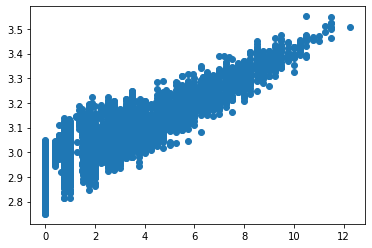

In [48]:
model_r = linear_model.Ridge(normalize= True, alpha= 70)
model_r.fit(X_train,y_train)
print('coef= ' , model_r.coef_)
print('intercept= ' , model_r.intercept_)

out = model_r.predict(X_test)
print(model_r.score(X = X_test, y = y_test, sample_weight=None))

plt.scatter(y_test, out)

In [49]:
def computeCost(X, y, theta):
    y1 = hypothesis(theta, X)
    y1=np.sum(y1, axis=1)
    return sum(np.sqrt((y1-y)**2))/(2*len(X))

def hypothesis(theta, X):
    return theta*X

def gradientDescent(X, y, theta, alpha, i):
    J = []  #cost function in each iterations
    k = 0
    while k < i:        
        y1 = hypothesis(theta, X)
        y1 = np.sum(y1, axis=1)
        for c in range(0, len(X.columns)):
            theta[c] = theta[c] - alpha*(sum((y1-y)*X.iloc[:,c])/len(X))
        j = computeCost(X, y, theta)
        J.append(j)
        k += 1
    return J, j, theta

def multi_lin_gradient(df, yVar, alpha): 
    # add in bias term
    df = pd.concat([pd.Series(1, index=df.index, name='00'), df], axis=1)
    df.head()
    
    # get x and y 
    X = df.drop(columns=[yVar])
    y = df[yVar]
    
    # normalize 
    for i in X.columns:
        X[i] = X[i]/np.max(X[i])
        
    # determine initial theta 
    theta = np.array([0]*len(X.columns))
    
    m = len(df)
    
    J, j, theta = gradientDescent(X, y, theta, alpha, 10)
    
    return J, j, theta

In [50]:
multi_lin_gradient(infl2, 'dependant', .005)

([1.555780609268932,
  1.555780609268932,
  1.555780609268932,
  1.555780609268932,
  1.555780609268932,
  1.555780609268932,
  1.555780609268932,
  1.555780609268932,
  1.555780609268932,
  1.555780609268932],
 1.555780609268932,
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

## Magnitude of Financial Data impacts Influence 

In [51]:
cf = pd.read_excel("/Users/natalie_kraft/Documents/LAS/AidDatasGlobalChineseDevelopmentFinanceDataset_v2.0.xlsx", sheet_name='Global_CDF2.0')

In [52]:
cf.loc[(cf['Recommended For Aggregates'] == 'Yes') & (cf['Commitment Year'] >= 2013)]['Amount (Constant USD2017)'].sum()

426989226273.48267

In [53]:
list(cf.columns)

['AidData TUFF Project ID',
 'Recommended For Aggregates',
 'Umbrella',
 'Financier Country',
 'Recipient',
 'Recipient Region',
 'Commitment Year',
 'Commitment Year Estimated',
 'Implementation Start Year',
 'Completion Year',
 'Title',
 'Description',
 'Staff Comments',
 'Status',
 'Intent',
 'Flow Type',
 'Concessional',
 'Flow Class',
 'Sector Code',
 'Sector Name',
 'Funding Agencies',
 'Funding Agencies Type',
 'Cofinanced',
 'Cofinancing Agencies',
 'Cofinancing Agencies Type',
 'Cofinancing Agencies Origin',
 'Receiving Agencies',
 'Receiving Agencies Type',
 'Receiving Agencies Origin',
 'Implementing Agencies',
 'Implementing Agencies Type',
 'Implementing Agencies Origin',
 'Accountable Agencies',
 'Accountable Agencies Type',
 'Accountable Agencies Origin',
 'Amount (Original Currency)',
 'Original Currency',
 'Amount (Constant USD2017)',
 'Amount (Nominal)',
 'Planned Implementation Start Date (MM/DD/YYYY)',
 'Planned Completion Date (MM/DD/YYYY)',
 'Actual Implementation

In [54]:
fin = cf.groupby('Recipient')['Amount (Constant USD2017)'].sum().sort_values().reset_index()

In [55]:
c = ii.groupby('country')['FAV_CHINA'].mean().reset_index()

c = c.merge(fin, left_on='country', right_on='Recipient')

In [56]:
# TODO: divide amount by GDP of that country in 2017 for comparison purposes 

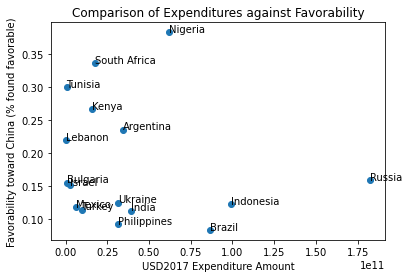

In [57]:
plt.scatter(c['Amount (Constant USD2017)'], c['FAV_CHINA'])
plt.title("Comparison of Expenditures against Favorability")
plt.xlabel("USD2017 Expenditure Amount")
plt.ylabel("Favorability toward China (% found favorable)")
for i, txt in enumerate(c['country']):
    plt.annotate(txt, (c['Amount (Constant USD2017)'][i], c['FAV_CHINA'][i]))

In [60]:
fin.head(50)

,Recipient,Amount (Constant USD2017)
0,Guam,0.000000e+00
1,Curacao,0.000000e+00
2,Sint Maarten (Dutch part),1.052750e+05
3,"Oceania, regional",1.249474e+06
4,Nicaragua,4.858309e+06
5,Kiribati,1.193206e+07
6,El Salvador,1.966304e+07
7,Niue,2.329016e+07
8,"Middle East, regional",5.111912e+07
9,Palau,5.214860e+07


In [65]:
c

,country,FAV_CHINA,Recipient,Amount (Constant USD2017)
0,Argentina,0.235410,Argentina,3.416706e+10
1,Brazil,0.083563,Brazil,8.654539e+10
2,Bulgaria,0.155242,Bulgaria,7.434414e+08
3,India,0.112832,India,3.926583e+10
4,Indonesia,0.122167,Indonesia,9.942730e+10
5,Israel,0.151066,Israel,2.654540e+09
6,Kenya,0.266461,Kenya,1.597156e+10
7,Lebanon,0.219876,Lebanon,1.711549e+08
8,Mexico,0.118357,Mexico,6.218526e+09
9,Nigeria,0.382538,Nigeria,6.181976e+10
